## Tracking points through a reconstruction

A consequence of having plate reconstructions with dynamically evolving plate boundaries is that we can define how a point moves through time, beginning on one plate but subsequently being transferred to other plates. For example:
- a point within an oceanic plate that subsequently splits into two plates
- a point on an oceanic plate that reaches a subduction zone (such that the crust may get subducted, or may become accreted to the overriding plate.

A geological example could be the products of a deep plume have ended up, assuming that 
1. the mantle plume produces seamounts (or thick crust) on the plate lying over it
2. these seamounts then travels with the plate, but later reaches a subduction zone where it is accreted to an active margin.

This notebook goes through the steps of defining a point at some moment in the geological past, finding out what plate it is on at this time, then tracking the motion of this point incrementally for a series of time steps, testing to see whether the point still lies within the boundaries of the plate that it started on.

##### Technical details
From a technical point of view, the process involves knowledge of:
- resolved topologies
- assigning plate ids using plate partitioning
- modifying the geometry of a feature


In [3]:
import pygplates
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


rotation_filename = 'Data/Seton_etal_ESR2012_2012.1.rot'

input_topology_filename = 'Data/Seton_etal_ESR2012_PP_2012.1.gpmlz'

topology_features = pygplates.FeatureCollection(input_topology_filename)
rotation_model = pygplates.RotationModel(rotation_filename)



In [4]:
# Alternative method using 'partition_geometry'

time_step = 2.
oldest_seed_time = 150.

# Empty array for storing Long/Lat of 
point_longitude = []
point_latitude = []
time_list = np.arange(oldest_seed_time,time_step,-time_step)

for seed_time in time_list:

    # Location of seed point for Kerguelen
    #seed_geometry = pygplates.PointOnSphere(-50, 80)
    
    # Seed point for Hawaii
    seed_geometry = pygplates.PointOnSphere(19, -155)

    for time in np.arange(seed_time,0.,-time_step):
        #print max_time, time

        # Get the plate polygons for this time
        resolved_topologies = []
        pygplates.resolve_topologies(topology_features, rotation_model, resolved_topologies, time)

        # make plate partitioner from polygons
        plate_partitioner = pygplates.PlatePartitioner(resolved_topologies, rotation_model)

        # Find the plate id of the polygon that contains the point
        partitioned_inside_geometries = []
        plate_partitioner.partition_geometry(seed_geometry, partitioned_inside_geometries)
        PlateID = partitioned_inside_geometries[0][0].get_feature().get_reconstruction_plate_id()
        #print PlateID

        # Get the stage rotation that will move the point from where it is at the current time
        # to its location at the next time step, based on the plate id that contains the point at the 
        # current time
        stage_rotation = rotation_model.get_rotation(time-time_step, PlateID, time, anchor_plate_id=1)

        # use the stage rotation to reconstruct the tracked point from position at current time 
        # to position at the next time step
        seed_geometry = stage_rotation * seed_geometry

    print 'seed time = %d, plume is within plate %i' % (seed_time, PlateID)
    
    point_longitude.append(seed_geometry.to_lat_lon_point().get_longitude())
    point_latitude.append(seed_geometry.to_lat_lon_point().get_latitude())

print('coordinates of reconstructed plume products')
print(zip(time_list,point_longitude,point_latitude))



seed time = 150, plume is within plate 301
seed time = 148, plume is within plate 301
seed time = 146, plume is within plate 301
seed time = 144, plume is within plate 301
seed time = 142, plume is within plate 301
seed time = 140, plume is within plate 301
seed time = 138, plume is within plate 301
seed time = 136, plume is within plate 301
seed time = 134, plume is within plate 301
seed time = 132, plume is within plate 301
seed time = 130, plume is within plate 301
seed time = 128, plume is within plate 301
seed time = 126, plume is within plate 101
seed time = 124, plume is within plate 101
seed time = 122, plume is within plate 101
seed time = 120, plume is within plate 406
seed time = 118, plume is within plate 406
seed time = 116, plume is within plate 406
seed time = 114, plume is within plate 406
seed time = 112, plume is within plate 406
seed time = 110, plume is within plate 406
seed time = 108, plume is within plate 406
seed time = 106, plume is within plate 406
seed time =

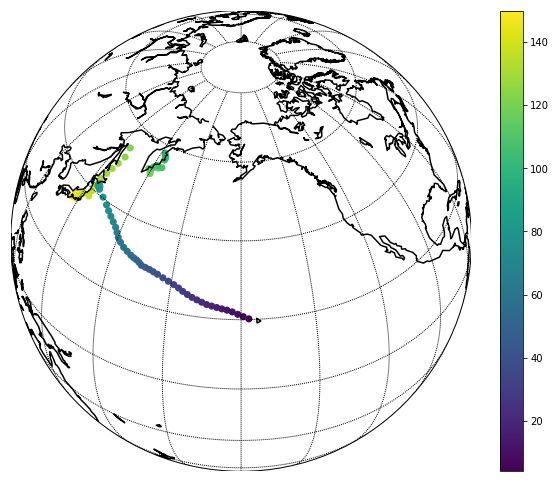

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, shiftgrid

m = Basemap(resolution='c',projection='ortho',lat_0=40.,lon_0=-160.)
# create figure, add axes
fig1 = plt.figure(figsize=(10,8))
ax = fig1.add_axes([0.1,0.1,0.8,0.8])

# compute native x,y coordinates of grid.
x, y = m(point_longitude, point_latitude)
m.scatter(x,y,c=time_list,s=50,edgecolor='',zorder=1)

# draw coastlines, parallels, meridians.
m.drawcoastlines(linewidth=1.5)
m.drawparallels(np.arange(-80.,90,20.))
m.drawmeridians(np.arange(0.,360.,20.))
# add colorbar
# set plot title
plt.colorbar()
plt.show()